In [1]:
import datasets
ds = datasets.load_dataset('yoonholee/deepscaler-from-solutions-o4-mini', split='train')
ds

Dataset({
    features: ['problem', 'answer', 'solution', 'note1', 'note2', 'note3', 'note4', 'note5'],
    num_rows: 40000
})

In [2]:
print(ds['problem'][0])

The operation $\otimes$ is defined for all nonzero numbers by $a \otimes b = \frac{a^{2}}{b}$. Determine $[(1 \otimes 2) \otimes 3] - [1 \otimes (2 \otimes 3)]$.


In [3]:
print(ds['note1'][0])

<description>When given a custom binary operation, always apply its defining rule directly to the arguments. Substituting the inputs into the general formula ensures a correct evaluation regardless of how the operation is written.</description>
<example>Suppose a binary operation ⊕ is defined by ⊕(x,y)=x²/y. To compute ⊕(m,n), replace x with m and y with n, yielding m²/n. For instance, ⊕(5,2)=25/2.</example>


In [4]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen3-1.7B-Base')

def generate_chat(query):
    dialogue = [
        {
            "role": "user",
            "content": f"""Given the following math problem, generate a list of insightful hints that help guide a student toward solving the problem. Each hint should be wrapped in a <note> block with the following structure:

<note>
<description>[Brief explanation of a key idea or technique relevant to the problem]</description>
<example>[Concrete illustrative example that demonstrates the idea in action]</example>
</note>
Combine all hint blocks inside a <notes> element. Your goal is to help the student reason through the problem step-by-step by surfacing useful strategies, intermediate goals, or simplifications.

Problem: {query}"""
        }
    ]
    dialogue = tokenizer.apply_chat_template(dialogue, tokenize=False, add_generation_prompt=True)
    return dialogue

In [5]:
print(generate_chat(ds['problem'][0]))

<|im_start|>user
Given the following math problem, generate a list of insightful hints that help guide a student toward solving the problem. Each hint should be wrapped in a <note> block with the following structure:

<note>
<description>[Brief explanation of a key idea or technique relevant to the problem]</description>
<example>[Concrete illustrative example that demonstrates the idea in action]</example>
</note>
Combine all hint blocks inside a <notes> element. Your goal is to help the student reason through the problem step-by-step by surfacing useful strategies, intermediate goals, or simplifications.

Problem: The operation $\otimes$ is defined for all nonzero numbers by $a \otimes b = \frac{a^{2}}{b}$. Determine $[(1 \otimes 2) \otimes 3] - [1 \otimes (2 \otimes 3)]$.<|im_end|>
<|im_start|>assistant



In [6]:
import prettytable
import datasets
import numpy as np
from math_eval import is_equiv
import xml.etree.ElementTree as ET
from xml.dom import minidom
from collections import defaultdict

def format_notes(notes_list: list[str]) -> str:
    """Format a list of notes into a single valid XML string."""
    valid_notes = [f"<note>{n}</note>" for n in notes_list]
    valid_notes_checked = []
    for vn in valid_notes:
        try:
            ET.fromstring(f"<note>{vn}</note>")
            valid_notes_checked.append(vn)
        except ET.ParseError:
            continue
    notes_root = ET.Element("notes")
    for note_str in valid_notes_checked:
        note_elem = ET.fromstring(note_str)
        notes_root.append(note_elem)
    rough_string = ET.tostring(notes_root, "unicode")
    reparsed = minidom.parseString(rough_string)
    xml_str = reparsed.toprettyxml(indent="  ")
    lines = [line for line in xml_str.split("\n") if line.strip() and not line.startswith("<?xml")]
    return "\n".join(lines)

In [7]:
all_notes = []
for i in range(1, 6):
    all_notes.append(ds[0][f'note{i}'])
print(format_notes(all_notes))

<notes>
  <note>
    <description>When given a custom binary operation, always apply its defining rule directly to the arguments. Substituting the inputs into the general formula ensures a correct evaluation regardless of how the operation is written.</description>
    <example>Suppose a binary operation ⊕ is defined by ⊕(x,y)=x²/y. To compute ⊕(m,n), replace x with m and y with n, yielding m²/n. For instance, ⊕(5,2)=25/2.</example>
  </note>
  <note>
    <description>Be aware that not all operations are associative, so the placement of parentheses can change the result. Always respect the indicated grouping when an operation lacks the associative property.</description>
    <example>With ⊕(x,y)=x²/y, compare ⊕(⊕(3,2),4) versus ⊕(3,⊕(2,4)). First gives ⊕(9/2,4)=(9/2)²/4=81/16, while the second gives ⊕(3,4/4)=3²/1=9, which are different.</example>
  </note>
  <note>
    <description>Handle nested expressions by simplifying from the innermost parentheses outward. This step-by-step approa

In [8]:
import os
def map_example(example):
    curr_problem = example['problem']
    query = generate_chat(curr_problem)
    all_notes = []
    for i in range(1, 6):
        all_notes.append(example[f'note{i}'])
    completion = format_notes(all_notes)
    
    example['query'] = query
    example['completion'] = completion
    return example

ds = ds.map(map_example, batched=False, num_proc=os.cpu_count(), remove_columns=ds.column_names)

ds[0]

{'query': '<|im_start|>user\nGiven the following math problem, generate a list of insightful hints that help guide a student toward solving the problem. Each hint should be wrapped in a <note> block with the following structure:\n\n<note>\n<description>[Brief explanation of a key idea or technique relevant to the problem]</description>\n<example>[Concrete illustrative example that demonstrates the idea in action]</example>\n</note>\nCombine all hint blocks inside a <notes> element. Your goal is to help the student reason through the problem step-by-step by surfacing useful strategies, intermediate goals, or simplifications.\n\nProblem: The operation $\\otimes$ is defined for all nonzero numbers by $a \\otimes b = \\frac{a^{2}}{b}$. Determine $[(1 \\otimes 2) \\otimes 3] - [1 \\otimes (2 \\otimes 3)]$.<|im_end|>\n<|im_start|>assistant\n',
 'completion': '<notes>\n  <note>\n    <description>When given a custom binary operation, always apply its defining rule directly to the arguments. Su

In [9]:
print(ds[0]['query'])
print(ds[0]['completion'])

<|im_start|>user
Given the following math problem, generate a list of insightful hints that help guide a student toward solving the problem. Each hint should be wrapped in a <note> block with the following structure:

<note>
<description>[Brief explanation of a key idea or technique relevant to the problem]</description>
<example>[Concrete illustrative example that demonstrates the idea in action]</example>
</note>
Combine all hint blocks inside a <notes> element. Your goal is to help the student reason through the problem step-by-step by surfacing useful strategies, intermediate goals, or simplifications.

Problem: The operation $\otimes$ is defined for all nonzero numbers by $a \otimes b = \frac{a^{2}}{b}$. Determine $[(1 \otimes 2) \otimes 3] - [1 \otimes (2 \otimes 3)]$.<|im_end|>
<|im_start|>assistant

<notes>
  <note>
    <description>When given a custom binary operation, always apply its defining rule directly to the arguments. Substituting the inputs into the general formula en

In [10]:
ds

Dataset({
    features: ['query', 'completion'],
    num_rows: 40000
})

In [12]:
def filter_fn(example):
    return example['completion'].count('<note>') == 5
ds = ds.filter(filter_fn, num_proc=os.cpu_count())
ds

Filter (num_proc=24):   0%|          | 0/40000 [00:00<?, ? examples/s]

Dataset({
    features: ['query', 'completion'],
    num_rows: 31430
})

In [13]:
ds_dict = ds.train_test_split(test_size=0.05, seed=42)
ds_dict

DatasetDict({
    train: Dataset({
        features: ['query', 'completion'],
        num_rows: 29858
    })
    test: Dataset({
        features: ['query', 'completion'],
        num_rows: 1572
    })
})

In [14]:
base_dir = '/home/anikait.singh/rl_behaviors_verl_stable/data_deepscaler_hint_sft_filtered'
os.makedirs(base_dir, exist_ok=True)
ds_dict['train'].to_parquet(os.path.join(base_dir, 'train.parquet'))
ds_dict['test'].to_parquet(os.path.join(base_dir, 'test.parquet'))

Creating parquet from Arrow format:   0%|          | 0/30 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

5720970

In [15]:
ds_dict.push_to_hub('Asap7772/deepscaler_hint_sft_qwen3-1.7b-base')

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/30 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Asap7772/deepscaler_hint_sft_qwen3-1.7b-base/commit/81a67455396e36a35091a8d287b1f067c8bb3f64', commit_message='Upload dataset', commit_description='', oid='81a67455396e36a35091a8d287b1f067c8bb3f64', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Asap7772/deepscaler_hint_sft_qwen3-1.7b-base', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Asap7772/deepscaler_hint_sft_qwen3-1.7b-base'), pr_revision=None, pr_num=None)

In [16]:
ds

Dataset({
    features: ['query', 'completion'],
    num_rows: 31430
})

In [17]:
def map_example(example):
    token_len = len(tokenizer(example['query'] + example['completion'])['input_ids'])
    example['token_len'] = token_len
    return example

ds = ds.map(map_example, batched=False, num_proc=os.cpu_count())

Map (num_proc=24):   0%|          | 0/31430 [00:00<?, ? examples/s]

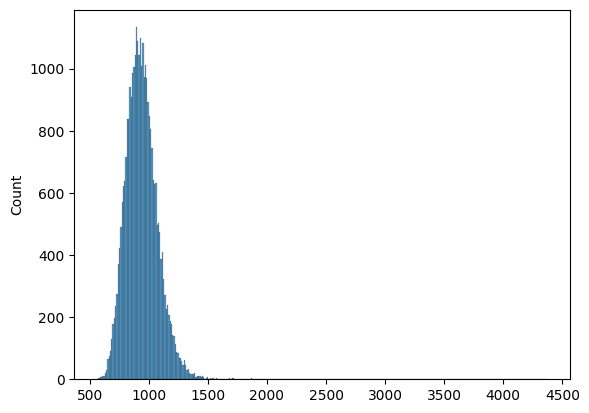

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(ds['token_len'])
plt.show()

In [19]:
import numpy as np
all_token_lens = np.array(ds['token_len'])
print('Mean token length: ', np.mean(all_token_lens))
print('Median token length: ', np.median(all_token_lens))
print('Max token length: ', np.max(all_token_lens))
print('Min token length: ', np.min(all_token_lens))
print('Std token length: ', np.std(all_token_lens))
print('99th percentile token length: ', np.percentile(all_token_lens, 99))
print('95th percentile token length: ', np.percentile(all_token_lens, 95))
print('90th percentile token length: ', np.percentile(all_token_lens, 90))


Mean token length:  941.9784918867324
Median token length:  931.0
Max token length:  4377
Min token length:  562
Std token length:  136.5300398464782
99th percentile token length:  1311.0
95th percentile token length:  1175.0
90th percentile token length:  1113.0


In [21]:
print(ds[0]['query'])
print(ds[0]['completion'])

<|im_start|>user
Given the following math problem, generate a list of insightful hints that help guide a student toward solving the problem. Each hint should be wrapped in a <note> block with the following structure:

<note>
<description>[Brief explanation of a key idea or technique relevant to the problem]</description>
<example>[Concrete illustrative example that demonstrates the idea in action]</example>
</note>
Combine all hint blocks inside a <notes> element. Your goal is to help the student reason through the problem step-by-step by surfacing useful strategies, intermediate goals, or simplifications.

Problem: The operation $\otimes$ is defined for all nonzero numbers by $a \otimes b = \frac{a^{2}}{b}$. Determine $[(1 \otimes 2) \otimes 3] - [1 \otimes (2 \otimes 3)]$.<|im_end|>
<|im_start|>assistant

<notes>
  <note>
    <description>When given a custom binary operation, always apply its defining rule directly to the arguments. Substituting the inputs into the general formula en